## Problem Statement: Document Clustering Using Topic Modelling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("Twenty_Newsgroups Dataset.csv")

In [3]:
df.head()

,Text,D_Number,Label,Email,Subject,Processed_text
0,From: mathew <mathew@mantis.co.uk>\nSubject: A...,49960,alt.atheism,mantis netcom mantis,alt atheism atheist resources,atheism resources resources december organizat...
1,From: mathew <mathew@mantis.co.uk>\nSubject: A...,51060,alt.atheism,mantis mantis mantis,alt atheism introduction to atheism,atheism introduction introduction april begin ...
2,From: I3150101@dbstu1.rz.tu-bs.de (Benedikt Ro...,51119,alt.atheism,dbstu1 edu mimsy umd edu umd,gospel dating,article other words one does not know what the...
3,From: mathew <mathew@mantis.co.uk>\nSubject: R...,51120,alt.atheism,mantis kepler edu unh,university violating separation of church state,recently ras have been ordered mathew
4,From: strom@Watson.Ibm.Com (Rob Strom)\nSubjec...,51121,alt.atheism,Ibm Watson harder ccr harder ccr watson ibm,soc motss et al princeton axes matching funds ...,box yorktown heights


In [4]:
df.sample(5)

,Text,D_Number,Label,Email,Subject,Processed_text
18186,From: hallam@dscomsa.desy.de (Phill Hallam-Bak...,179102,talk.politics.misc,desy dscomsa nwfocus halcyon apollo EDU TEMPLE...,waco burning,yes have heard that the survivors are now sayi...
1665,From: dclunie@pax.tpa.com.au (David Clunie)\nS...,39052,comp.graphics,pax tpa edu washington shelley edu washington ...,easy to translate jpeg code,does anyone out there have any jpeg decompress...
13350,From: alan@lancaster.nsc.com (The Hepburn)\nSu...,59394,sci.med,lancaster nsc edu rhaller uoregon edu uoregon ...,resound hearing aids and others,have fairly severe high frequency hearing loss...
12917,From: ls8139@albnyvms.bitnet (larry silverberg...,58958,sci.med,bitnet albnyvms edu Albany gemini,h e l p m e desperate with some vd,can probably buy the tools and this solution s...
12666,From: Mark W. Dubin\nSubject: Re: ringing ears...,58111,sci.med,53iss6 Waterloo NCR,ringing ears,friend mine has trouble with her ears ringing ...


In [5]:
import re
import string
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\baghe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
def preprocess(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove emails
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    
    # Remove very large or very short words
    text = re.sub(r'\b\w{1,2}\b|\b\w{13,}\b', '', text)
    
    # Remove digits
    text = re.sub(r'\d+', '', text)
    
    # Remove specific frequent words
    frequent_words = set(['article', 'email', 'write', 'writes', 'wrote', 'subject', 're'])
    text = ' '.join(word for word in text.split() if word.lower() not in frequent_words)
    
    return text

In [7]:
df.shape

(18828, 6)

In [8]:
df.isnull().sum()

Text                0
D_Number            0
Label               0
Email              64
Subject             1
Processed_text    100
dtype: int64

In [9]:
df.dropna(inplace=True)

In [10]:
df.isnull().sum()

Text              0
D_Number          0
Label             0
Email             0
Subject           0
Processed_text    0
dtype: int64

In [11]:
df.shape

(18664, 6)

In [12]:
df["Label"].value_counts()

Label
rec.sport.hockey            992
rec.motorcycles             991
rec.sport.baseball          988
sci.crypt                   988
sci.space                   982
rec.autos                   981
soc.religion.christian      979
sci.med                     976
comp.windows.x              973
sci.electronics             971
comp.os.ms-windows.misc     969
comp.graphics               967
comp.sys.ibm.pc.hardware    966
misc.forsale                957
comp.sys.mac.hardware       950
talk.politics.mideast       938
talk.politics.guns          903
alt.atheism                 795
talk.politics.misc          774
talk.religion.misc          624
Name: count, dtype: int64

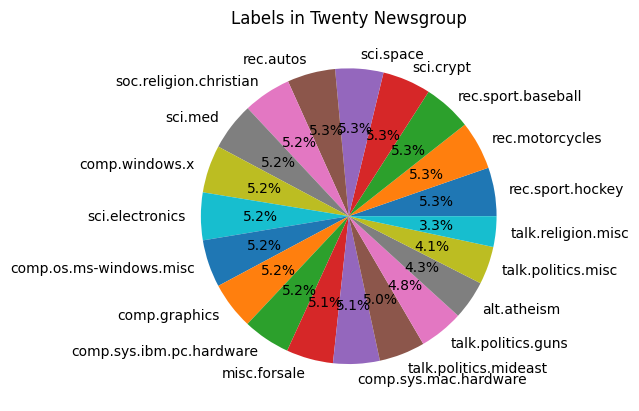

In [13]:
plt.pie(df["Label"].value_counts(),labels=df["Label"].value_counts().index,autopct='%1.1f%%')
plt.title("Labels in Twenty Newsgroup")
plt.savefig(r"C:\Users\baghe\OneDrive\Desktop\Document Clustering Using KMeans\static\Labels in dataset.png",transparent=True)
plt.show()

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18664 entries, 0 to 18827
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Text            18664 non-null  object
 1   D_Number        18664 non-null  int64 
 2   Label           18664 non-null  object
 3   Email           18664 non-null  object
 4   Subject         18664 non-null  object
 5   Processed_text  18664 non-null  object
dtypes: int64(1), object(5)
memory usage: 1020.7+ KB


In [15]:
y = df["Label"]

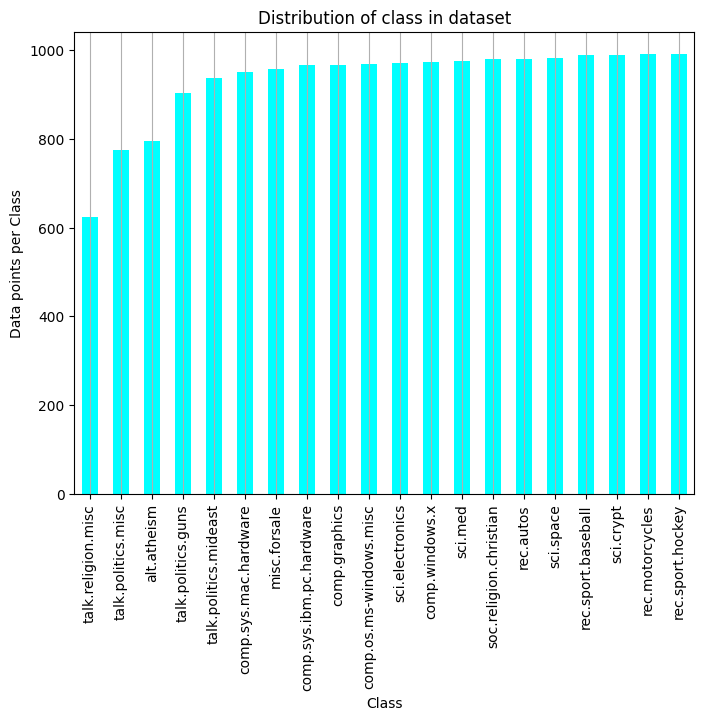

In [16]:
class_distribution = y.value_counts().sort_values()
plt.figure(figsize=(8, 6))
class_distribution.plot(kind = "bar", color = "cyan")

plt.xlabel("Class")
plt.ylabel("Data points per Class")
plt.title("Distribution of class in dataset")
plt.grid(axis='x')
plt.savefig(r"C:\Users\baghe\OneDrive\Desktop\Document Clustering Using KMeans\static\labels.png",transparent=True)
plt.show()

In [17]:
df.Processed_text[0]

'atheism resources resources december organizations usa freedom from religion foundation darwin fish bumper stickers and assorted other atheist paraphernalia are available from the freedom from religion foundation the volume contains comprehensive review the principal arguments for and against the existence god ranges from the classical philosophical positions through the moral arguments newman kant and the recent restatements the classical theses and also addresses those positions which push the concept god beyond the realm the rational such those kierkegaard kung and well replacements for god such axiarchism the book delight read less formalistic and better written than works and refreshingly direct when compared with the hand waving james haught illustrated history religious murder and madness looks religious persecution from ancient times the present day and not only congress catalog card number norm allen the listing for african americans for humanism above gordon stein atheism an

In [18]:
texts = df['Processed_text'].fillna('')

In [19]:
texts[0]

'atheism resources resources december organizations usa freedom from religion foundation darwin fish bumper stickers and assorted other atheist paraphernalia are available from the freedom from religion foundation the volume contains comprehensive review the principal arguments for and against the existence god ranges from the classical philosophical positions through the moral arguments newman kant and the recent restatements the classical theses and also addresses those positions which push the concept god beyond the realm the rational such those kierkegaard kung and well replacements for god such axiarchism the book delight read less formalistic and better written than works and refreshingly direct when compared with the hand waving james haught illustrated history religious murder and madness looks religious persecution from ancient times the present day and not only congress catalog card number norm allen the listing for african americans for humanism above gordon stein atheism an

In [20]:
text_data = " ".join(df['Processed_text'])

In [21]:
from wordcloud import WordCloud

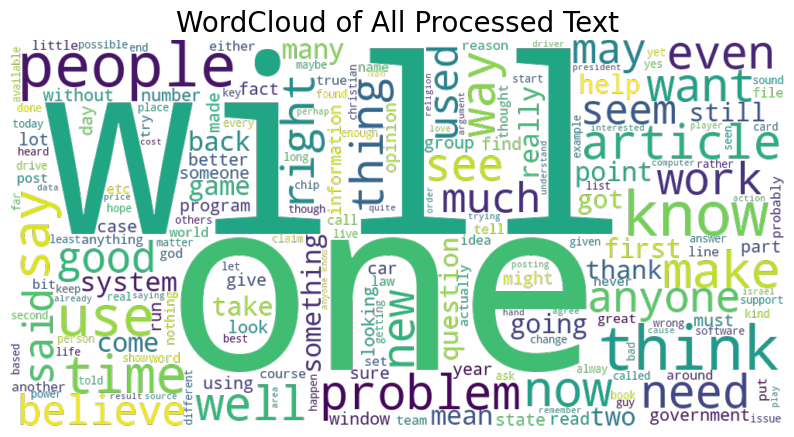

In [22]:
wordcloud = WordCloud(width=1000, height=500, background_color=None,mode='RGBA', colormap='viridis').generate(text_data)

# Plot
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of All Processed Text", fontsize=20)
plt.savefig(r"C:\Users\baghe\OneDrive\Desktop\Document Clustering Using KMeans\static\wordcloud.png",transparent=True)
plt.show()

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [24]:
vectorizer = TfidfVectorizer(lowercase=True,max_features=1000,
                      #selecting top 200 features by term frequency
                             max_df=0.7, # Ignore terms that appear in more than 70% of the documents
                             min_df=4,  # Ignore terms that appear in fewer than 4 documents
 # Consider unigrams, bigrams, and trigrams
                             stop_words = "english")
X = vectorizer.fit_transform(texts)

In [25]:
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df.head()

,ability,able,absolutely,accept,access,according,account,act,action,actions,...,written,wrong,wrote,yeah,year,years,yes,yesterday,york,young
0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.104119,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
1,0.0,0.011269,0.0,0.0,0.0,0.013583,0.0,0.0,0.0,0.030164,...,0.000000,0.022637,0.0,0.0,0.0,0.020519,0.011658,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0


In [26]:
tfidf_df.shape

(18664, 1000)

In [27]:
from sklearn.cluster import KMeans

In [28]:
wcss = []
K = range(2, 21)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)  # X = your TF-IDF matrix
    wcss.append(kmeans.inertia_)  # Within-Cluster Sum of Squares

C:\Users\baghe\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\baghe\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\baghe\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 501, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\baghe\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 966, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\baghe\AppData\Local\Programs\Python\Python310\lib\subp

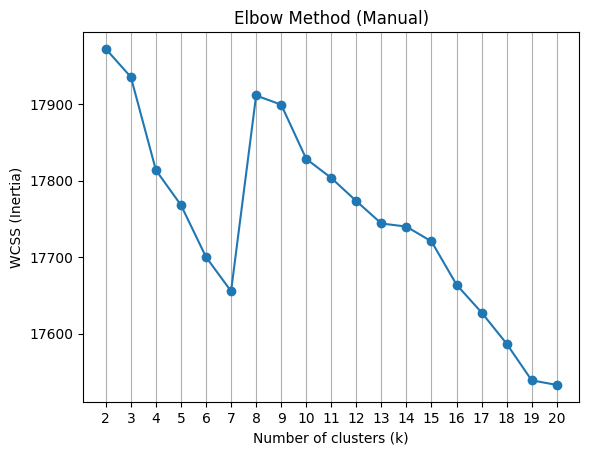

In [29]:
plt.plot(K, wcss, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.title('Elbow Method (Manual)')
plt.grid(axis='x')
plt.xticks(K)
plt.savefig(r"C:\Users\baghe\OneDrive\Desktop\Document Clustering Using KMeans\static\Elbow method.png",transparent=True)
plt.show()

In [30]:
kmeans = KMeans(n_clusters=20, random_state=42)  # or any k
kmeans.fit(X)
df['Cluster'] = kmeans.labels_

In [31]:
df.head()

,Text,D_Number,Label,Email,Subject,Processed_text,Cluster
0,From: mathew <mathew@mantis.co.uk>\nSubject: A...,49960,alt.atheism,mantis netcom mantis,alt atheism atheist resources,atheism resources resources december organizat...,18
1,From: mathew <mathew@mantis.co.uk>\nSubject: A...,51060,alt.atheism,mantis mantis mantis,alt atheism introduction to atheism,atheism introduction introduction april begin ...,18
2,From: I3150101@dbstu1.rz.tu-bs.de (Benedikt Ro...,51119,alt.atheism,dbstu1 edu mimsy umd edu umd,gospel dating,article other words one does not know what the...,6
3,From: mathew <mathew@mantis.co.uk>\nSubject: R...,51120,alt.atheism,mantis kepler edu unh,university violating separation of church state,recently ras have been ordered mathew,6
4,From: strom@Watson.Ibm.Com (Rob Strom)\nSubjec...,51121,alt.atheism,Ibm Watson harder ccr harder ccr watson ibm,soc motss et al princeton axes matching funds ...,box yorktown heights,6


In [32]:
new_text = "box yorktown heights"

In [33]:
new_text_vector = vectorizer.transform([new_text])

In [34]:
predicted_cluster = kmeans.predict(new_text_vector)
print("Predicted Cluster:", predicted_cluster[0])

Predicted Cluster: 6


In [35]:
from sklearn.metrics import silhouette_score
cluster_labels = kmeans.labels_
score = silhouette_score(X, cluster_labels)

print(f"Silhouette Score: {score:.4f}")

Silhouette Score: -0.0098


In [36]:
cluster_to_category = df.groupby('Cluster')['Label'].agg(lambda x: x.mode()[0]).to_dict()

In [37]:
cluster_to_category

{0: 'rec.autos',
 1: 'comp.sys.ibm.pc.hardware',
 2: 'comp.os.ms-windows.misc',
 3: 'comp.windows.x',
 4: 'comp.sys.mac.hardware',
 5: 'comp.windows.x',
 6: 'talk.politics.mideast',
 7: 'sci.crypt',
 8: 'rec.sport.hockey',
 9: 'rec.sport.baseball',
 10: 'comp.windows.x',
 11: 'comp.os.ms-windows.misc',
 12: 'rec.sport.hockey',
 13: 'talk.politics.misc',
 14: 'talk.politics.misc',
 15: 'comp.sys.ibm.pc.hardware',
 16: 'rec.autos',
 17: 'rec.sport.hockey',
 18: 'soc.religion.christian',
 19: 'sci.space'}

In [38]:
predicted_category = cluster_to_category.get(predicted_cluster[0], "Unknown Category")
predicted_category

'talk.politics.mideast'

In [39]:
def get_cluster_probabilities(vector, kmeans_model):
    # Get distances to each cluster center
    distances = kmeans_model.transform(vector)[0]
    
    # Convert distances to similarity (lower distance → higher similarity)
    similarities = 1 / (distances + 1e-10)  # Avoid divide-by-zero
    
    # Normalize similarities to get "probabilities"
    probabilities = similarities / similarities.sum()
    
    return probabilities

In [40]:
# Get cluster "probabilities"
probabilities = get_cluster_probabilities(X, kmeans)

# Map cluster index to category names
labels = [cluster_to_category[i] for i in range(len(probabilities))]

# Plot the probabilities as a bar graph
plt.figure(figsize=(12, 6))
plt.bar(labels, probabilities, color='skyblue')
plt.xticks(rotation=90)
plt.title('Cluster Probabilities')
plt.tight_layout()
plt.savefig("static/cluster_probabilities.png")
plt.close()


In [41]:
# label_counts = df[df["Cluster"] == predicted_cluster[0]]["Label"].value_counts()
# top_label = label_counts.index[0]
# confidence = label_counts.iloc[0] / label_counts.sum()
# print(label_counts)
# print("Predicted Label:", top_label)
# print("Confidence:", round(confidence * 100, 2), "%")


In [42]:
# ComputerTechnology = ["comp.graphics","comp.os.ms-windows.misc","comp.sys.ibm.pc.hardware","comp.sys.mac.hardware","comp.windows.x"]
# Recreation = ["rec.autos","rec.motorcycles","rec.sport.baseball","rec.sport.hockey"]
# Science = ["sci.crypt","sci.electronics","sci.med","sci.space"]
# Miscellaneous = ["misc.forsale"]
# Society = ["talk.politics.misc","talk.politics.guns","talk.politics.mideast","talk.religion.misc","alt.atheism","soc.religion.christian"]

In [43]:
# if(top_label in ComputerTechnology):
#     print("Category: Computer Technology")
# if(top_label in Recreation):
#     print("Category: Recreation / Sports")
# # if(top_label in Science):
#     print("Category: Science")
# if(top_label in Miscellaneous):
#     print("Category: Miscellaneous")
# if(top_label in Society):
#     print("Category: Politics / Religion / Society")

In [44]:
def get_top_keywords(kmeans, vectorizer, cluster_id, n_terms=10):
    centroids = kmeans.cluster_centers_
    terms = vectorizer.get_feature_names_out()
    top_indices = centroids[cluster_id].argsort()[::-1][:n_terms]
    return [terms[i] for i in top_indices]

top_words = get_top_keywords(kmeans, vectorizer, predicted_cluster[0])
print("Top keywords in this cluster:", top_words)

Top keywords in this cluster: ['article', 'people', 'just', 'like', 'think', 'did', 'does', 'time', 'know', 'right']


In [45]:
words = ""
for word in top_words:
    words = words+" "+word
print(words)

 article people just like think did does time know right


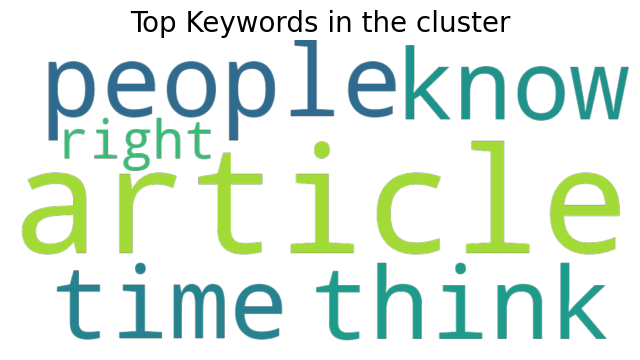

In [46]:
# Generate WordCloud
wordcloud = WordCloud(width=1000, height=500, background_color=None,mode='RGBA', colormap='viridis').generate(words)

# Plot
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Top Keywords in the cluster", fontsize=20)
plt.show()


In [47]:
# Get indices of cluster centers
centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

# Get the feature names
terms = vectorizer.get_feature_names_out()

i = 1
# Loop through each cluster and print the top 10 terms
for cluster in centroids:
    print (f"Cluster {i}")
    
    for keyword in cluster[0:10]:
        print (terms[keyword])
        
    print ("")
    i=i+1

Cluster 1
thing
luck
possibly
america
safety
reference
series
display
unless
version

Cluster 2
looking
motherboard
drives
bus
tape
greatly
wait
figure
states
board

Cluster 3
ftp
edu
site
file
program
files
thanks
know
drivers
does

Cluster 4
trying
help
use
know
thanks
like
program
just
make
people

Cluster 5
interesting
speed
heard
cpu
logic
machines
earlier
require
mode
allowed

Cluster 6
server
window
run
sun
does
file
running
bit
using
problem

Cluster 7
article
people
just
like
think
did
does
time
know
right

Cluster 8
key
encryption
chip
keys
pgp
escrow
government
clipper
public
use

Cluster 9
conference
best
press
results
nhl
computer
calls
curious
handle
encryption

Cluster 10
games
game
baseball
year
season
know
win
think
like
hockey

Cluster 11
code
source
does
looking
know
thanks
like
good
program
help

Cluster 12
thanks
know
does
windows
mail
use
card
like
help
looking

Cluster 13
game
espn
baseball
hockey
play
night
did
year
goal
time

Cluster 14
large
black
curious
day


In [48]:
from sklearn.decomposition import PCA

In [49]:
pca = PCA(n_components=2, random_state=42)
X_reduced = pca.fit_transform(X.toarray())  # Convert sparse matrix to dense

In [50]:
labels = kmeans.labels_

In [51]:
centroids_reduced = pca.transform(kmeans.cluster_centers_)

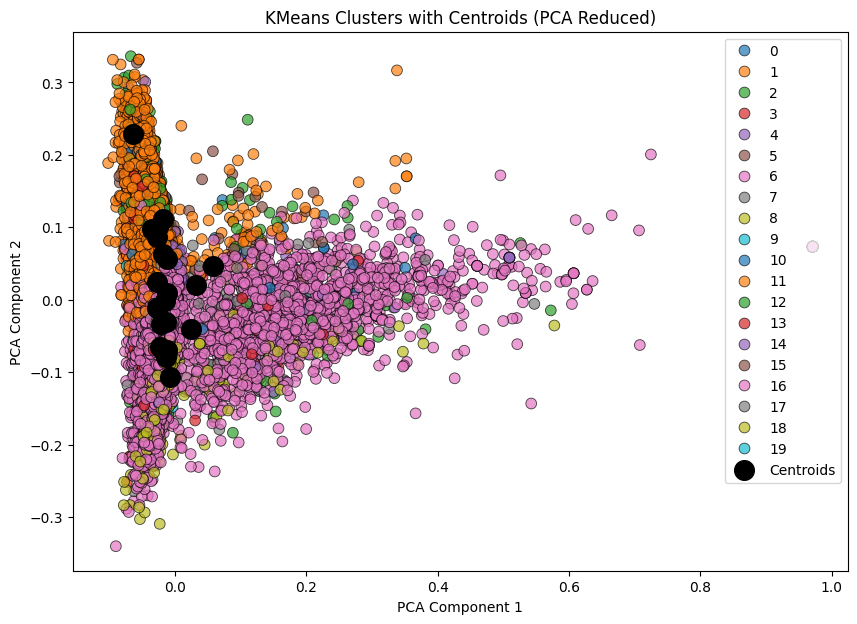

In [52]:
plt.figure(figsize=(10, 7))

# Plot the documents
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=labels, palette='tab10', s=60, alpha=0.7, edgecolor='k')

# Plot the centroids
plt.scatter(centroids_reduced[:, 0], centroids_reduced[:, 1], 
            s=200, c='black', marker='o', label='Centroids')

plt.title("KMeans Clusters with Centroids (PCA Reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
# plt.grid(True)
plt.savefig(r"C:\Users\baghe\OneDrive\Desktop\Document Clustering Using KMeans\static\cluster_graph.png",transparent=True)
plt.show()

In [56]:
import joblib
joblib.dump(kmeans,open("KMeans-clustering.pkl",'wb'))
joblib.dump(vectorizer,open("Vectorizer.pkl",'wb'))